In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import cv2

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data cleaning

The objective of this section is to clearly separate the train and test dataset.

In [ ]:
# The images and labels are to be loaded from the following sources
IMG_BASE = '/kaggle/input/covidxct/3A_images/'
LABELS_train = '/kaggle/input/covidxct/train_COVIDx_CT-3A.txt'
LABELS_test = '/kaggle/input/covidxct/test_COVIDx_CT-3A.txt'
SUMMARY = '/kaggle/input/covidxct/metadata.csv'

# Class names, in order of index
CLASSES = ('NORMAL', 'PNEUMONIA', 'COVID-19')

# Checkpoints available at
CHECKPOINT = "CT.keras"

# Define the dimensions of the image
height = 256
width = 256

In [ ]:
# The following modules will be employed for pre-processing the training data

def process_row(row):
    fname, cls, xmin, ymin, xmax, ymax = row.strip('\n').split()
    bboxes = (int(xmin), int(ymin), int(xmax), int(ymax))
    
    image = load_img(IMG_BASE, fname, bboxes)

    return image, cls
    

def load_img(IMG_BASE, fname, bbox=None):
    """Loads and preprocesses images for inference"""
    image_file = IMG_BASE + fname
    # Load and crop image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    if bbox is not None:
        image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    image = cv2.resize(image, (width, height), cv2.INTER_CUBIC)

    # Convert to float in range [0, 1]
    image = image.astype(np.float32) / 255.0

    # Shift to tensorflow
    image =  tf.image.convert_image_dtype(image, dtype=tf.float32)
    return tf.reshape(image, [height, width, 1])

def find_row_with_string(filename, search_string):
    try:
        with open(filename, 'r') as file:
            for line in file:
                if search_string in line:
                    # The below randomisation is to ensire that the other CT images are also accessed and not just the first one
                    # This is to help increase the amount of training data used
                    if random.random() < 1/5:
                        return line.strip()
                    else:
                        pass
    except FileNotFoundError:
        print("File not found.")

# Data retrieval

In [ ]:
df = pd.read_csv(SUMMARY)
df.head()

In [ ]:
Diagnoses = df['finding'].unique()

# Split the DataFrame based on the 'finding' column
df_covid = df[df['finding'] == 'COVID-19']
df_pneumonia = df[df['finding'] == 'Pneumonia']
df_normal = df[df['finding'] == 'Normal']

data = [df_normal, df_pneumonia, df_covid]

for diag in data:
    print(diag.count())

In [ ]:
def DataProd(n, label_src):
    # n gives the number of samples from each class to be included in the dataset produced

    x_list = []
    y_list = []
    error = 0

    y_i = 0

    for diag in data:
        samp = diag.sample(n) # Randomly sample n elements from the dataset
    
        for index, row in samp.iterrows():
            try:
                img_data = find_row_with_string(label_src, row['patient id'])
                x, y = process_row(img_data)
                x_list.append(x)
                if int(y) == (y_i): # this is to verify that the images are labelled appropriately in the text files
                    y_list.append(int(y))
                else:
                    print("Fatal Data Flaw. Data in text file modified!")
                    print("Classes:", y, y_i)
                    y_list.append(int(y_i))
            except:
                error += 1
                pass

        y_i += 1

    print("The missing rate for images is ", error / ( len(y_list) + error))
    print("The number of images is ", len(y_list))

    indices = random.sample(range(len(x_list)), len(x_list))

    x_list = [x_list[i] for i in indices]
    y_list = [y_list[i] for i in indices]

    return tf.stack(x_list), tf.constant(y_list)

In [ ]:
x_list, y_list = DataProd(40, LABELS_train)

In [ ]:
index = 12
# Test what the image looks like
plt.imshow(x_list[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()
print(CLASSES[y_list[index]])

# Model Building

In [ ]:
model = tf.keras.Sequential()

model.add(layers.Input(shape=(height, width, 1)))

# Convolution layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# Output layer with 3 neurons (for classification into 3 classes)
model.add(layers.Dense(3, activation='softmax'))  # Use softmax for multi-class classification

learning_rate = 0.0005 # Define the learning rate for the neural network

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['mean_squared_error', 'accuracy'])

model.summary()

In [ ]:
num_batches = 10
batch_size = 50 # The actual size of batch will be approximately batch_size * 3 * 0.7
epochs = 15
training_runs = 100

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT,
                                                 verbose=1,
                                                 monitor="val_accuracy",
                                                 save_best_only=True,
                                                 mode="max",)

In [ ]:
for i in range(training_runs):
    x_list, y_list = DataProd(num_batches * batch_size, LABELS_train)
    y_list = tf.one_hot(y_list, 3).numpy()
    
    history = model.fit(
        x_list,
        y_list,
        batch_size=batch_size,
        epochs=5,
        validation_split=0.1,
        callbacks=[cp_callback],
    ) 
    
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'], color='red')
    plt.ylim(0, 1)

In [ ]:
# There is a bit of overfitting that needs to be addressed

In [ ]:
def PredictType(image):
    # This function returns the class of the image in terms of its position in CLASSES
    pred = model.predict(tf.reshape(x_list[3], (1, x_list[3].shape[0], x_list[3].shape[1], x_list[3].shape[2]) ))
    return tf.math.argmax(pred[0])

## Model testing

In [ ]:
def GetMetrics(x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = (y_pred > 0.5).astype('int32')
    y_pred_classes = [np.argmax(y_pred_classes[i]) for i in range(len(y_pred_classes))]
    y_pred_classes = np.array(y_pred_classes)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=CLASSES)
    
    # Print metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"AUC: {auc}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    disp.plot()
    plt.show()

In [ ]:
# Get the test data first of all
x_test, y_test = DataProd(200, LABELS_test)

# Calculate the metrics
GetMetrics(x_test, y_test)

# Segmentation model

## Create masked images

In [ ]:
num_box = 16

def ImageMaskGenerator(image):
    """
    Takes a 256x256x1 grayscale image and returns 256 images,
    each with one distinct num_box x num_box box filled with its average pixel value.
    
    Args:
        image (tf.Tensor): A 256x256x1 grayscale image.

    Returns:
        List[tf.Tensor]: List of 256 images with averaged boxes.
    """
    if image.shape != (256, 256, 1):
        raise ValueError("Input image must have shape (256, 256, 1)")

    images_with_averaged_boxes = []

    # Create 16x16 boxes
    for row in range(num_box):
        for col in range(num_box):
            # Create a copy of the image
            modified_image = tf.identity(image)

            # Calculate the start and end indices for the box
            start_row, end_row = row * num_box, (row + 1) * num_box
            start_col, end_col = col * num_box, (col + 1) * num_box

            # Calculate the average pixel value in the box
            box = image[start_row:end_row, start_col:end_col, 0]
            avg_value = tf.reduce_mean(box)

            # Fill the box with the average value
            modified_image = tf.tensor_scatter_nd_update(
                modified_image,
                indices=tf.constant(
                    [[r, c, 0] for r in range(start_row, end_row) for c in range(start_col, end_col)],
                    dtype=tf.int32
                ),
                updates=tf.fill([num_box * num_box], avg_value)
            )

            images_with_averaged_boxes.append(modified_image)

    return tf.stack(images_with_averaged_boxes)

In [ ]:
index = 126
i_data = 1
MImg = ImageMaskGenerator(x_list[i_data])
# Test what the image looks like
plt.imshow(MImg[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()
print(CLASSES[tf.argmax(y_list[i_data])])

## Feed images in NN and see deviation

In [ ]:
def GetRef(image):
    pred = model.predict(tf.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]) ))
    ref = tf.math.reduce_max(pred)
    return ref

def normalize_and_reshape(tensor: tf.Tensor) -> tf.Tensor:
    """
    Normalizes a TensorFlow tensor of length num_box*num_box to [0, 1] and reshapes to num_box x num_box.

    Args:
        tensor (tf.Tensor): A TensorFlow tensor of length num_box * num_box.

    Returns:
        tf.Tensor: A 16x16 TensorFlow image.
    """
    if tensor.shape != (num_box * num_box,):
        raise ValueError("Input tensor must have shape (num_box * num_box,)")

    # Normalize the tensor to [0, 1]
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    normalized_tensor = (tensor - min_val) / (max_val - min_val + 1e-7)

    # Reshape the tensor into a 16x16 image
    image = tf.reshape(normalized_tensor, (num_box, num_box, 1))

    return tf.image.resize(image, (256, 256) ,method="mitchellcubic")

In [ ]:
img_segment = x_list[3]

MImg = ImageMaskGenerator(img_segment)
res = model.predict(MImg)
ref = GetRef(img_segment)
cls = int(PredictType(img_segment))

print(f"This image is of type {CLASSES[cls]}")

In [ ]:
mask_probs = []

for r in res:
    if r[cls] < ref:
        mask_probs.append(ref - r[cls])
    else:
        mask_probs.append(0)

mask_probs = tf.stack(mask_probs)

In [ ]:
res[0][2]

In [ ]:
masks = normalize_and_reshape(mask_probs)

In [ ]:
# Visualise the effects the different masks have on the image
plt.imshow(masks, cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
def overlay_red_highlight(base_image: tf.Tensor, overlay_image: tf.Tensor) -> tf.Tensor:
    """
    Overlays a red highlight on a grayscale image using a second grayscale image.

    Args:
        base_image (tf.Tensor): A 256x256x1 grayscale image.
        overlay_image (tf.Tensor): A 256x256x1 grayscale image.

    Returns:
        tf.Tensor: A 256x256x3 RGB image with red highlights.
    """
    if base_image.shape != (256, 256, 1) or overlay_image.shape != (256, 256, 1):
        raise ValueError("Both images must have shape (256, 256, 1)")

    # Normalize overlay image to [0, 1]
    min_val = tf.reduce_min(overlay_image)
    max_val = tf.reduce_max(overlay_image)
    normalized_overlay = (overlay_image - min_val) / (max_val - min_val + 1e-7)

    # Create RGB channels
    red_channel = base_image + normalized_overlay
    green_channel = base_image
    blue_channel = base_image

    # Concatenate to get an RGB image
    rgb_image = tf.concat([red_channel, green_channel, blue_channel], axis=-1)

    return rgb_image

In [ ]:
segmented_img = overlay_red_highlight(img_segment, masks)

In [ ]:
# Visualise the effects the different masks have on the image
plt.imshow(segmented_img, vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()

# If the entire image is red-tinted, then it is a strong indication that the classification is incorrect.

print(f"The red highlighted segments show the regions that indicate that the image corresponds to {CLASSES[cls]}.")

# Severity identification

In [ ]:
# Here we look at the Per-COVID 19 dataset
PER_IMG_BASE = '/kaggle/input/per-covid-19/Database1/Images/'
PER_LABELS_BASE = '/kaggle/input/per-covid-19/'

SEG_CHECKPOINT = "Severity.keras"

columns = ["Image Name", "COVID-19 Infection Percentage", "Fold Split", "Subject ID"]

dfs = pd.read_excel(PER_LABELS_BASE + 'Database_new.xlsx', header=None, names=columns)

In [ ]:
y_sev = []
x_img = []

for index, row in dfs.iterrows():
    y_sev.append(row[columns[1]])
    x_img.append(load_img(PER_IMG_BASE, row[columns[0]]))

# For the purpose to enabing the neural network to process the y_values, tranform them to between 0 and 1
y_sev = [k/100 for k in y_sev]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_img, y_sev, test_size=0.1, random_state=11)

X_train = tf.stack(X_train)
X_test = tf.stack(X_test)
y_train = tf.constant(y_train)
y_test = [k * 100 for k in y_test]

In [ ]:
index = 111
# Test what the image looks like
plt.imshow(x_img[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()
print(f"This image is {y_sev[index] * 100}% infected")

In [ ]:
def sample_images_with_labels(tensor: tf.Tensor, labels: tf.Tensor, num_samples: int = 300):
    """
    Randomly samples `num_samples` images and their corresponding labels.
    
    Parameters:
        tensor (tf.Tensor): Input tensor of shape (n, 256, 256, 1), where n > num_samples.
        labels (tf.Tensor or list): Corresponding labels of shape (n,).
        num_samples (int): Number of images to sample. Default is 300.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing:
            - Sampled images tensor of shape (num_samples, 256, 256, 1).
            - Sampled labels tensor of shape (num_samples,).
    """
    n = tf.shape(tensor)[0]
    assert n > num_samples, "Input tensor must have more than 300 images."
    assert tf.shape(labels)[0] == n, "Labels must have the same number of elements as images."
    
    indices = tf.random.shuffle(tf.range(n))[:num_samples]
    sampled_tensor = tf.gather(tensor, indices)
    sampled_labels = tf.gather(labels, indices)
    
    return sampled_tensor, sampled_labels

In [ ]:
SegModel = tf.keras.Sequential()

SegModel.add(layers.Input(shape=(height, width, 1)))

# Convolution layers
SegModel.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
SegModel.add(layers.MaxPooling2D((2, 2)))

SegModel.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
SegModel.add(layers.MaxPooling2D((2, 2)))

SegModel.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
SegModel.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
SegModel.add(layers.Flatten())

# Fully connected layers
SegModel.add(layers.Dense(128, activation='relu'))
SegModel.add(layers.Dense(64, activation='relu'))

# Output layer with 1 neurons (for the predicted value)
SegModel.add(layers.Dense(1, activation='sigmoid'))  # Use sigmoid for regression

learning_rate = 0.0005 # Define the learning rate for the neural network

SegModel.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error', 'accuracy'])

SegModel.summary()

# The main challenege in training a regression model is to ensure that the model 
# does not settle at just predicting the mean value of the datatset.

In [ ]:
epochs = 5
batch_size = 200
num_bacthes = 5
training_runs = 1

seg_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=SEG_CHECKPOINT,
                                                 verbose=1,
                                                 monitor="val_loss",
                                                 save_best_only=True,
                                                 mode="min",)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1560 - loss: 0.0590 - mean_absolute_error: 0.0590 
Epoch 1: val_loss improved from 0.07382 to 0.06876, saving model to Severity.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 264s 15s/step - accuracy: 0.1559 - loss: 0.0590 - mean_absolute_error: 0.0590 - val_accuracy: 0.1337 - val_loss: 0.0688 - val_mean_absolute_error: 0.0688
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1605 - loss: 0.0555 - mean_absolute_error: 0.0555 
Epoch 2: val_loss improved from 0.06876 to 0.06599, saving model to Severity.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 282s 17s/step - accuracy: 0.1602 - loss: 0.0555 - mean_absolute_error: 0.0555 - val_accuracy: 0.1337 - val_loss: 0.0660 - val_mean_absolute_error: 0.0660
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1522 - loss: 0.0527 - mean_absolute_error: 0.0527 
Epoch 3: val_loss did not improve from 0.06599
17/17 ━━━━━━━━━━━━━━━━━━━━ 277s 15s/step - accuracy: 0.1524 - loss: 0.0527 - mean_a

(0.0, 1.0)

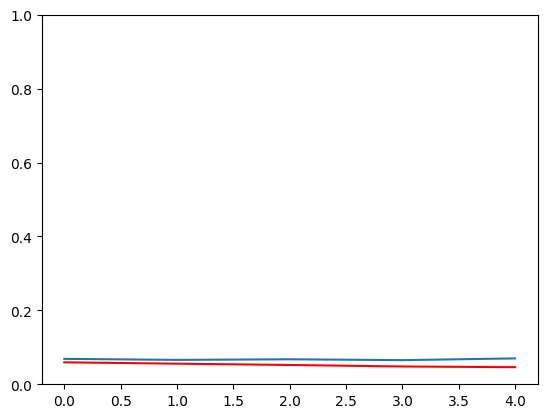

In [84]:
# This approach is used for regression
history = SegModel.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[seg_cp_callback],
) 
# For regression, you are not trying to maximise accuracy but minimise loss

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'], color='red')
plt.ylim(0, 1)

In [ ]:
# This approach is used for small batch training where the data is changed each time
# This method does not work very well for regression
for x in range(training_runs):

    train_x, train_y = sample_images_with_labels(X_train, y_train, batch_size * num_bacthes)
    
    history = SegModel.fit(
        train_x,
        train_y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=[seg_cp_callback],
    ) 
    # For regression, you are not trying to maximise accuracy but minimise loss

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'], color='red')
plt.ylim(0, 1)

In [ ]:
def GetScoreResult(X_test):
    y_pred = SegModel.predict(X_test)
    y_pred = y_pred * 100
    y_pred = y_pred.reshape(-1)

    return y_pred

In [85]:
y_pred = GetScoreResult(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
loss = mean_absolute_error(y_test, y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 725ms/step


In [86]:
y_pred

array([71.44659   ,  9.501768  ,  9.173286  ,  4.6796207 ,  0.60417897,
        1.1560075 , 12.155095  ,  8.639569  , 85.38821   ,  7.2746224 ,
       55.125713  ,  2.4901934 ,  5.0915775 , 74.06473   , 42.94423   ,
       48.69241   , 25.683632  , 73.975     , 64.70789   , 90.78964   ,
        4.5847707 , 44.39273   , 10.9204855 ,  8.557092  ,  9.834466  ,
        2.937766  ,  0.8457449 , 62.61803   ,  4.973654  , 64.65268   ,
       10.315753  ,  3.1818573 , 38.28642   , 31.246582  ,  2.882895  ,
       28.175009  , 12.094016  , 15.924547  , 17.312996  ,  1.1503549 ,
       16.276146  ,  1.8468287 , 15.9342785 ,  2.8002183 , 78.97317   ,
       39.910606  , 88.84697   , 10.136876  , 18.181038  ,  1.9217502 ,
        8.233878  , 28.583447  ,  5.8570724 , 82.76641   , 12.242815  ,
       34.95513   , 30.20223   , 13.407001  ,  2.643957  , 66.07094   ,
        4.15948   ,  1.4706916 , 68.98461   ,  5.5651946 ,  7.093541  ,
        2.962751  ,  1.8679574 ,  6.445395  , 83.025024  ,  5.09

In [ ]:
print(f"""The model yielded
r2 score: {r2}
mse score: {mse ** 0.5}
loss: {loss}""")

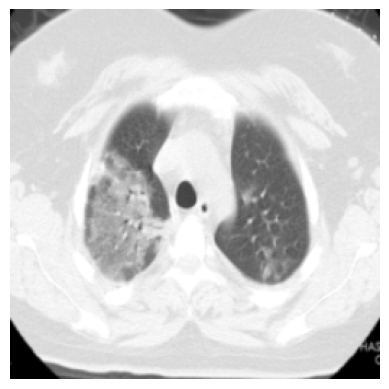

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
This image is 42.94422268867493% infected
The actual percent infected is 34.0%.


In [88]:
index = 14
# Test what the image looks like
plt.imshow(X_test[index], cmap='gray', vmin=0, vmax=1)
plt.axis("off")  # Hide axes
plt.show()

pred = SegModel.predict(tf.reshape(X_test[index], (1, height, width, 1)))[0]

print(f"This image is {pred[0] * 100}% infected")
print(f"The actual percent infected is {y_test[index]}%.")